In [188]:
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AdamW, BertConfig

import re
import os
import random
import time
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [155]:
train_df = pd.read_csv("../input/funnysemval/data/task-2/train.csv")
valid_df = pd.read_csv("../input/funnysemval/data/task-2/dev.csv")
test_df = pd.read_csv("../input/funnysemval/data/task-2/test_without_label.csv")

In [156]:
test_df_label = pd.read_csv("../input/funnysemval/data/task-2/test_with_label.csv")

In [157]:
train_df.head()

,id,original1,edit1,grades1,meanGrade1,original2,edit2,grades2,meanGrade2,label
0,10920-9866,""" Gene Cernan , Last <Astronaut/> on the Moon ...",Dancer,1113,1.2,""" Gene Cernan , Last Astronaut on the Moon , <...",impregnated,30001,0.8,1
1,3176-10722,""" I 'm done "" : Fed up with California , some ...",vagrants,1200,0.6,""" I 'm done "" : Fed up with <California/> , so...",pancakes,10110,0.6,0
2,3176-3702,""" I 'm done "" : Fed up with California , some ...",vagrants,1200,0.6,""" I 'm done "" : Fed up with <California/> , so...",life,2,0.4,1
3,10722-3702,""" I 'm done "" : Fed up with <California/> , so...",pancakes,10110,0.6,""" I 'm done "" : Fed up with <California/> , so...",life,2,0.4,1
4,12282-2083,""" Our expectations of what civic engagement lo...",imagine,0,0.0,""" Our expectations of what civic engagement <l...",smells,100220010,0.6,2


In [158]:
valid_df.head()

,id,original1,edit1,grades1,meanGrade1,original2,edit2,grades2,meanGrade2,label
0,61-5576,""" Nutella <riots/> "" erupt in France over disc...",brownies,21100,0.8,""" Nutella <riots/> "" erupt in France over disc...",sales,11000,0.4,1
1,61-11943,""" Nutella <riots/> "" erupt in France over disc...",brownies,21100,0.8,""" Nutella riots "" erupt in France over discoun...",Bunnies,32110,1.4,2
2,5576-11943,""" Nutella <riots/> "" erupt in France over disc...",sales,11000,0.4,""" Nutella riots "" erupt in France over discoun...",Bunnies,32110,1.4,2
3,12581-9120,$ 45 billion added to health care bill for opi...,party,3322222100,1.7,$ 45 billion added to health care bill for opi...,Handouts,32210,1.6,1
4,3605-11504,"' 400,000 <People/> ... Live In Hell On Earth ...",Goats,21000,0.6,"' 400,000 People ... Live In Hell On Earth ' :...",Disinfecting,10000,0.2,1


In [159]:
test_df.head()

,id,original1,edit1,original2,edit2
0,704-2704,""" Pence Is Trying to Control Republican Politi...",barbers,""" Pence Is Trying to <Control/> Republican Pol...",Bungle
1,704-14395,""" Pence Is Trying to Control Republican Politi...",barbers,""" <Pence/> Is Trying to Control Republican Pol...",Witch
2,2704-14395,""" Pence Is Trying to <Control/> Republican Pol...",Bungle,""" <Pence/> Is Trying to Control Republican Pol...",Witch
3,11098-10186,""" There is no Man Behind the Curtain , "" says ...",elephant,""" There is no Man Behind the Curtain , "" says ...",woman
4,11098-2118,""" There is no Man Behind the Curtain , "" says ...",elephant,""" There is no Man Behind the Curtain , "" says ...",man


In [160]:
def get_pair(sent_orig, edit_word):
    o = re.sub("[</>]", "", sent_orig)
    e = (sent_orig.split("<"))[0] + edit_word + (sent_orig.split(">"))[1]

    return e, o

In [161]:
train_df.head()

,id,original1,edit1,grades1,meanGrade1,original2,edit2,grades2,meanGrade2,label
0,10920-9866,""" Gene Cernan , Last <Astronaut/> on the Moon ...",Dancer,1113,1.2,""" Gene Cernan , Last Astronaut on the Moon , <...",impregnated,30001,0.8,1
1,3176-10722,""" I 'm done "" : Fed up with California , some ...",vagrants,1200,0.6,""" I 'm done "" : Fed up with <California/> , so...",pancakes,10110,0.6,0
2,3176-3702,""" I 'm done "" : Fed up with California , some ...",vagrants,1200,0.6,""" I 'm done "" : Fed up with <California/> , so...",life,2,0.4,1
3,10722-3702,""" I 'm done "" : Fed up with <California/> , so...",pancakes,10110,0.6,""" I 'm done "" : Fed up with <California/> , so...",life,2,0.4,1
4,12282-2083,""" Our expectations of what civic engagement lo...",imagine,0,0.0,""" Our expectations of what civic engagement <l...",smells,100220010,0.6,2


In [162]:
train_df.loc[0]['original1']

'" Gene Cernan , Last <Astronaut/> on the Moon , Dies at 82 "'

In [163]:
class SentencePair(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.df = dataframe
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.pad = self.tokenizer.pad_token_id
        self.cls = [self.tokenizer.cls_token_id]
        self.sep = [self.tokenizer.sep_token_id]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        grade = torch.tensor(self.df["mean_Grade"][idx],dtype=torch.float32)
        sent_e, sent_o = get_pair(self.df["original"][idx], self.df["edit"][idx])
        sent_e_tokens = (self.cls+ self.tokenizer.encode(sent_e, add_special_tokens=False)+ self.sep)
        sent_o_tokens = (self.tokenizer.encode(sent_o, add_special_tokens=False) + self.sep)
#         print(sent_e_tokens)
        token_type_ids = (torch.tensor([0] * len(sent_e_tokens) + [1] * (self.max_len - len(sent_e_tokens)))).long()
        attention_mask = torch.tensor([1] * (len(sent_o_tokens) + len(sent_e_tokens))+ [0] * (self.max_len - len(sent_o_tokens) - len(sent_e_tokens)))
        attention_mask = attention_mask.float()
        input_ids = torch.tensor(sent_o_tokens + sent_e_tokens)
#         print(input_ids)
#         print(attention_mask)
        if len(input_ids) < self.max_len:
            input_ids = torch.cat((input_ids,(torch.ones(self.max_len - len(input_ids)) * self.pad).long(),))
            token_type_ids = torch.cat((token_type_ids,(torch.ones(self.max_len - len(token_type_ids)) * self.pad).long(),))
        elif len(input_ids) > self.max_len:
            input_ids = input_ids[: self.max_len]
            token_type_ids = token_type_ids[: self.max_len]

        return input_ids, token_type_ids, attention_mask, grade

In [164]:
temp = train_df
total_data_df = temp
#Reducing size due to computation res limitations 
#Originally we trained on the whole dataset It ran succ(first time) on kaggle and we have presented results on the basis of that 
#but after that it started giving us error (Notebook disconnected)
total_df_1 = total_data_df[["id", "original1", "edit1", "meanGrade1"]]
total_df_2 = total_data_df[["id", "original2", "edit2", "meanGrade2"]]

test_df['meanGrade']=[0]*len(test_df)
test_df_1 = test_df[["id", "original1", "edit1", "meanGrade"]]
test_df_2 = test_df[["id", "original2", "edit2", "meanGrade"]]

print(total_df_1.shape)
print(total_df_2.shape)
print(test_df_1.shape)


(9381, 4)
(9381, 4)
(2960, 4)


In [165]:
valid_df_1 = valid_df[["id", "original1", "edit1", "meanGrade1"]]
valid_df_2 = valid_df[["id", "original2", "edit2", "meanGrade2"]]
print(valid_df_1.shape)
print(valid_df_2.shape)

(2355, 4)
(2355, 4)


In [166]:
test_df_1.reset_index(drop=True,inplace=True)
test_df_2.reset_index(drop=True,inplace=True)

In [167]:
total_df_1.rename(columns={"original1": "original", "edit1": "edit", "meanGrade1": "mean_Grade"},inplace=True,)
total_df_2.rename(columns={"original2": "original", "edit2": "edit", "meanGrade2": "mean_Grade"},inplace=True,)
test_df_1.rename(columns={"original1": "original", "edit1": "edit", "meanGrade": "mean_Grade"},inplace=True,)
test_df_2.rename(columns={"original2": "original", "edit2": "edit", "meanGrade": "mean_Grade"},inplace=True,)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [168]:
valid_df_1.rename(columns={"original1": "original", "edit1": "edit", "meanGrade1": "mean_Grade"},inplace=True,)
valid_df_2.rename(columns={"original2": "original", "edit2": "edit", "meanGrade2": "mean_Grade"},inplace=True,)

In [169]:
train_merge=total_df_1.append(total_df_2,ignore_index=True)
valid_merge=valid_df_1.append(valid_df_2,ignore_index=True)

In [170]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
df1 = SentencePair(total_df_1, tokenizer, max_len=256)
df2 = SentencePair(total_df_2, tokenizer, max_len=256)
train_df_l = SentencePair(train_merge, tokenizer, max_len=256)


valid_df_ = SentencePair(valid_merge, tokenizer, max_len=256)

test_1 = SentencePair(test_df_1, tokenizer, max_len=256)
test_2 = SentencePair(test_df_2, tokenizer, max_len=256)

In [171]:
#  for i, data in enumerate(total_loader_1):
#         input_ids, token_type_ids, attention_mask, grade = data
#         print(input_ids,attention_mask)
#         break
df1_loader = DataLoader(df1, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
df2_loader = DataLoader(df2, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
train_loader=DataLoader(train_df_l, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)



valid_loader=DataLoader(valid_df_, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test_loader1=DataLoader(test_1, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader2=DataLoader(test_2, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [173]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple,DataLoader)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [174]:

train_loader = to_device(train_loader,device)

valid_loader = to_device(valid_loader,device)

test_loader1 = to_device(test_loader1,device)
test_loader2 = to_device(test_loader2,device)

In [175]:
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).to(device,non_blocking=True)
# model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [176]:
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [177]:
# #Fine tuning Bert for our task
preds = []
loss_stat =[]
total_loss=0
training_stat=[]
# model.eval()
epochs=30
count=0
start_time = time.time()
for epoch in range(epochs):
    total_loss=0
    count=0
    print('== Epoch {:} / {:} =='.format(epoch + 1, epochs))
    print('Training for this epoch')
    for i, data in enumerate(train_loader):
        model.zero_grad()
        input_ids, token_type_ids, attention_mask, grade = data
        outputs = model(
            input_ids=input_ids,
            labels=grade,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss, logits = outputs[:2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss+=loss.item()
        loss_stat.append(loss)
        for logit in logits.reshape(-1):
            preds.append(logit.item())
        count+=1
        print("Batch done out of 587:",count)
    
    avg_training_loss=total_loss/len(train_loader)
    print("Average training loss:",avg_training_loss)
    
    #Validation==============================
    #Uncomment this for validation loss 
    ## WARNING-> It will take lot of time 
    print("running validation")
    valid_preds=[]
    val_loss=0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            input_ids, token_type_ids, attention_mask, grade = data
            outputs = model(
                input_ids=input_ids,
                labels=grade,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            loss, logits = outputs[:2]
            val_loss+=loss.item()
            for logit in logits.reshape(-1):
                valid_preds.append(logit.item())
        training_stat.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_training_loss,
            'Valid. Loss': val_loss/len(valid_loader),
        }
        
    )
        print("--- %s seconds ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))


== Epoch 1 / 30 ==
Training for this epoch
Batch done out of 587: 1
Batch done out of 587: 2
Batch done out of 587: 3
Batch done out of 587: 4
Batch done out of 587: 5
Batch done out of 587: 6
Batch done out of 587: 7
Batch done out of 587: 8
Batch done out of 587: 9
Batch done out of 587: 10
Batch done out of 587: 11
Batch done out of 587: 12
Batch done out of 587: 13
Batch done out of 587: 14
Batch done out of 587: 15
Batch done out of 587: 16
Batch done out of 587: 17
Batch done out of 587: 18
Batch done out of 587: 19
Batch done out of 587: 20
Batch done out of 587: 21
Batch done out of 587: 22
Batch done out of 587: 23
Batch done out of 587: 24
Batch done out of 587: 25
Batch done out of 587: 26
Batch done out of 587: 27
Batch done out of 587: 28
Batch done out of 587: 29
Batch done out of 587: 30
Batch done out of 587: 31
Batch done out of 587: 32
Batch done out of 587: 33
Batch done out of 587: 34
Batch done out of 587: 35
Batch done out of 587: 36
Batch done out of 587: 37
Batc

In [178]:
test_1 = []
count=0
with torch.no_grad():
    for i, data in enumerate(test_loader1):
        input_ids, token_type_ids, attention_mask, grade = data
        outputs = model(
            input_ids=input_ids,
            labels=grade,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        _, logits = outputs[:2]

        for logit in logits.reshape(-1):
            test_1.append(logit.item())
        count+=1
        print("Batch done out of 93:",count)

Batch done out of 93: 1
Batch done out of 93: 2
Batch done out of 93: 3
Batch done out of 93: 4
Batch done out of 93: 5
Batch done out of 93: 6
Batch done out of 93: 7
Batch done out of 93: 8
Batch done out of 93: 9
Batch done out of 93: 10
Batch done out of 93: 11
Batch done out of 93: 12
Batch done out of 93: 13
Batch done out of 93: 14
Batch done out of 93: 15
Batch done out of 93: 16
Batch done out of 93: 17
Batch done out of 93: 18
Batch done out of 93: 19
Batch done out of 93: 20
Batch done out of 93: 21
Batch done out of 93: 22
Batch done out of 93: 23
Batch done out of 93: 24
Batch done out of 93: 25
Batch done out of 93: 26
Batch done out of 93: 27
Batch done out of 93: 28
Batch done out of 93: 29
Batch done out of 93: 30
Batch done out of 93: 31
Batch done out of 93: 32
Batch done out of 93: 33
Batch done out of 93: 34
Batch done out of 93: 35
Batch done out of 93: 36
Batch done out of 93: 37
Batch done out of 93: 38
Batch done out of 93: 39
Batch done out of 93: 40
Batch don

In [179]:
test_2 = []
count=0
with torch.no_grad():
    for i, data in enumerate(test_loader2):
        input_ids, token_type_ids, attention_mask, grade = data
        outputs = model(
            input_ids=input_ids,
            labels=grade,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        _, logits = outputs[:2]

        for logit in logits.reshape(-1):
            test_2.append(logit.item())
        count+=1
        print("Batch done out of 93:",count)

Batch done out of 93: 1
Batch done out of 93: 2
Batch done out of 93: 3
Batch done out of 93: 4
Batch done out of 93: 5
Batch done out of 93: 6
Batch done out of 93: 7
Batch done out of 93: 8
Batch done out of 93: 9
Batch done out of 93: 10
Batch done out of 93: 11
Batch done out of 93: 12
Batch done out of 93: 13
Batch done out of 93: 14
Batch done out of 93: 15
Batch done out of 93: 16
Batch done out of 93: 17
Batch done out of 93: 18
Batch done out of 93: 19
Batch done out of 93: 20
Batch done out of 93: 21
Batch done out of 93: 22
Batch done out of 93: 23
Batch done out of 93: 24
Batch done out of 93: 25
Batch done out of 93: 26
Batch done out of 93: 27
Batch done out of 93: 28
Batch done out of 93: 29
Batch done out of 93: 30
Batch done out of 93: 31
Batch done out of 93: 32
Batch done out of 93: 33
Batch done out of 93: 34
Batch done out of 93: 35
Batch done out of 93: 36
Batch done out of 93: 37
Batch done out of 93: 38
Batch done out of 93: 39
Batch done out of 93: 40
Batch don

In [180]:
#should be true
len(test_1)==len(test_2)

True

In [181]:
final_preds=[]

for i in range(len(test_1)):
    if(test_1[i]>test_2[i]):
        final_preds.append(1)
    elif(test_1[i]<test_2[i]):
        final_preds.append(2)
    else:
        final_preds.append(0)

Text(0, 0.5, 'loss')

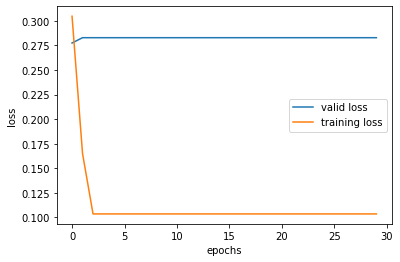

In [193]:
training_loss = []
valid_loss = []
for stat in training_stat:
    training_loss.append(stat['Training Loss'])
    valid_loss.append(stat['Valid. Loss'])
sns.lineplot(data=valid_loss,)
sns.lineplot(data=training_loss)
plt.legend(['valid loss',"training loss"])
plt.xlabel('epochs')
plt.ylabel('loss')

In [186]:
from sklearn.metrics import classification_report
print(classification_report(test_df_label['label'].tolist(),final_preds))

              precision    recall  f1-score   support

           0       0.40      0.01      0.01       332
           1       0.56      0.67      0.61      1289
           2       0.58      0.62      0.60      1339

    accuracy                           0.57      2960
   macro avg       0.52      0.43      0.41      2960
weighted avg       0.55      0.57      0.54      2960



In [185]:
import pickle 
with open('final_task2_preds.pickle', 'wb') as handle:
    pickle.dump(model , handle, protocol=pickle.HIGHEST_PROTOCOL)